In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import time
from datetime import datetime, timedelta

In [3]:
# read the data
df_gps = pd.read_excel("Data_Radiosonde/GpsResults.xlsx")
df_ptu = pd.read_excel("Data_Radiosonde/PtuResults.xlsx")

In [4]:
# function to calculate the height from the pressure, with hydrostatic approximation
def height_from_pressure(p2, p1=1007,rho=1.15, g=9.81):
    dp = p1 - p2
    dz = dp / (rho * g)
    return dz

## WXT data

In [43]:
df_wxt = pd.read_csv("Data_WXT/20250827.txt", skiprows=6, delimiter=';') # times in df_wxt are UTC + 1

## Plots from Radiosonde data

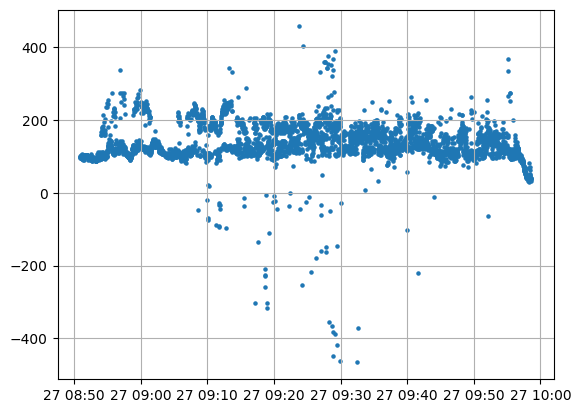

In [7]:
# plot Altitude from GPS
# plt.scatter(df_gps['Time'][1:],df_gps['Altitude'][1:], marker='o', s=5)
plt.scatter(df_gps['Time'][1397:],df_gps['Altitude'][1397:], marker='o', s=5)
plt.grid();

In [22]:
#df_ptu['Time'][1:3683] # 8:51 bis 9:52 UTC
#df_wxt
type(df_ptu['Time'][1])

datetime.datetime

In [36]:
# resample radiosonde data to one data point per minute
df_ptu['Time'] = pd.to_datetime(df_ptu['Time'][1:])

# 'time' als Index setzen
df_ptu = df_ptu.set_index('Time')

# Mittelwert pro Minute berechnen
df_min = df_ptu['Pressure'][1:].resample('1T').mean().reset_index()

KeyError: 'Time'

In [79]:
# convert time in df_wxt data frame and select specific times
date_str = "2025-08-27"
datetime_strs = [f"{date_str} {t}" for t in df_wxt['TIME']]
df_wxt['time_combined'] = pd.to_datetime(datetime_strs) # add new column

start_time = pd.to_datetime(date_str + " 09:51:00")  # times in df_wxt are UTC + 1
end_time   = pd.to_datetime(date_str + " 10:51:00")  # times in df_wxt are UTC + 1
mask = (df_wxt['time_combined'] >= start_time) & (df_wxt['time_combined'] <= end_time)
df_wxt_filtered = df_wxt.loc[mask]

#df_wxt_filtered

In [100]:
# calculate altitude with continous reference pressure
altitude_cont = height_from_pressure(np.float64(df_min['Pressure'][:61]), p1=df_wxt_filtered['PTB_P'][:])

# save calculated altitude in a csv file
df_alt_cont = pd.DataFrame({
    "time": np.array(df_min['Time'][:61]),
    "altitude": np.array(altitude_cont) * 100
})

# Save to CSV
df_alt_cont.to_csv("Data_WXT/20250827_altitude_kite_from_wxt.csv", index=False)

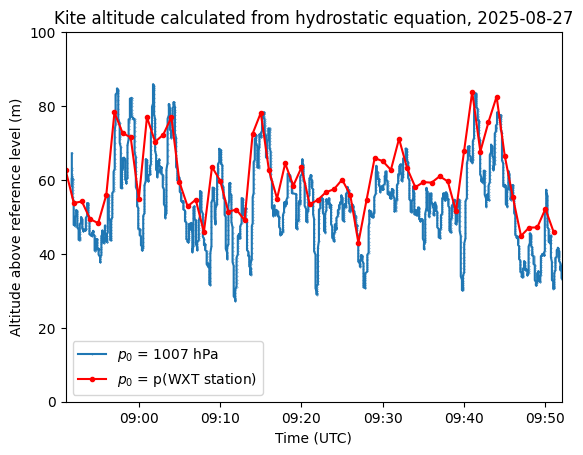

In [115]:
# plot altitude from hydrostatic approximation
fig = plt.figure()
plt.plot(df_ptu[1:3683].index,height_from_pressure(df_ptu['Pressure'][1:3683])*100, '.-',markersize=0.5, label = r'$p_0$ = 1007 hPa')
plt.plot(df_min['Time'][:61],altitude_cont*100, '.-', color='red',label = r'$p_0$ = p(WXT station)')
plt.xlim(df_min['Time'][0], df_min['Time'][61])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim(0,100)
plt.title(r'Kite altitude calculated from hydrostatic equation, 2025-08-27')
plt.ylabel('Altitude above reference level (m)')
plt.xlabel('Time (UTC)')
plt.legend()
plt.show()
fig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)

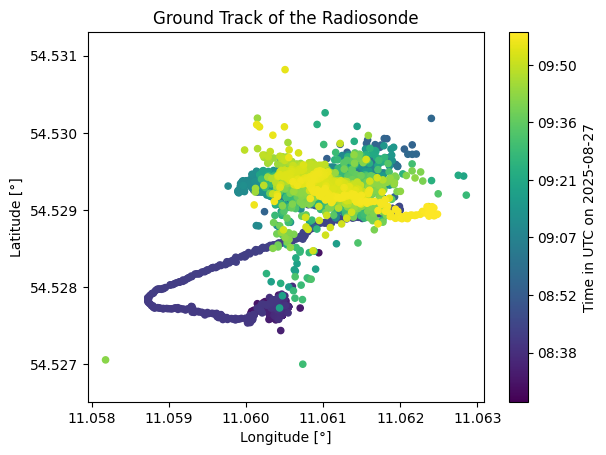

In [9]:
# plot ground track
time_num = mdates.date2num(df_gps['Time'][1:])  # convert to float

fig = plt.figure()
sc = plt.scatter(df_gps['Longitude'][1:], df_gps['Latitude'][1:], c=time_num, cmap="viridis", s=20)
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ground Track of the Data_Radiosonde")
plt.axis("equal")
cbar = plt.colorbar(sc, label="Time in UTC on 2025-08-27")
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()
fig.savefig('Plots/20250827_Radiosonde_ground_track.png', dpi=300)

## Plots from PTU data

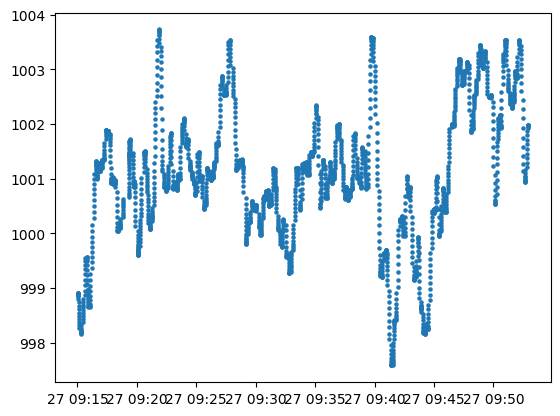

In [10]:
# plot the Pressure
#plt.scatter(df_ptu['Time'][1:],df_ptu['Pressure'][1:], marker='o', s=5)
plt.scatter(df_ptu['Time'][1397:3683],df_ptu['Pressure'][1397:3683], marker='o', s=5);

## Theodolite data

In [11]:
theo = pd.read_csv("Data_Theodolite/theodolite_202508271110_202508271153.csv")

In [12]:
file_path = "Data_Theodolite/TheoRot_20250827_150544.txt"

# Read all lines first
with open(file_path, "r") as f:
    lines = f.readlines()
# Skip last three lines
lines = lines[:-3]
# Lists to store data
time_sec = []
value1 = []
value2 = []

for line in lines:
    line = line.strip()
    if line.startswith("D"):  # data line
        parts = line.split()
        time_sec.append(float(parts[1]))
        value1.append(float(parts[2]))
        value2.append(float(parts[3]))
    elif line.startswith("S"):
        print("Metadata:", line)  # optional

azimuth = np.array(value1) + (231.1-123.93)
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
# Create DataFrame
df_theo = pd.DataFrame({
    "time_sec": [start_time + timedelta(seconds=s) for s in time_sec],
    "azimuth": azimuth,
    "elevation": value2})

Metadata: S 25/08/27 09:08:09


NameError: name 'start_time' is not defined

In [13]:
theo["real_azimuth"] = theo["azimuth"] + (231.1-123.93)  # correction term using the light house
# theo["real_azimuth"] = [t - 360. if t >= 360 else t for t in theo["real_azimuth"]]
theo["time"] = [datetime.strptime(d, "%H:%M").time() for d in theo["time"]]
theo["time"] = [datetime.combine(date(2025,8,27), t) for t in theo["time"]]

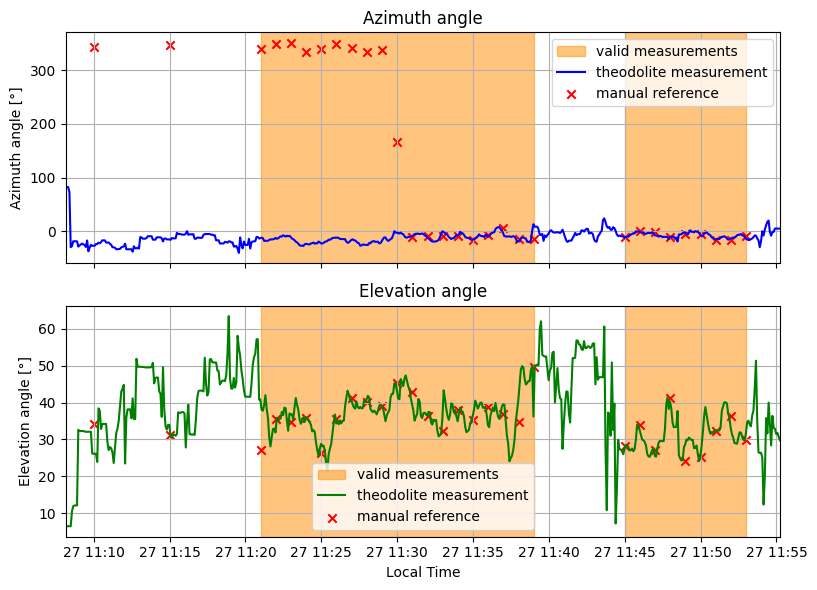

In [19]:
# start at index number 84 (or later)
valid1 = datetime(2025, 8, 27, 11, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 11, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 11, 45, 0)  # 2025-08-27 11:21:00
valid4 = datetime(2025, 8, 27, 11, 53, 0)  # 2025-08-27 11:39:00
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# First subplot: value1 vs time
angles_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(df_theo['azimuth'])))
real_azimuth2 = theo["real_azimuth"].copy()
real_azimuth2[real_azimuth2 > 360] = real_azimuth2[real_azimuth2 > 360] - 360
angles_unwrapped_manual = np.rad2deg(np.unwrap(np.deg2rad(real_azimuth2)))
yticks = [-40, -20, 0, 20, 40, 60, 80]
ytick_labels = [320, 340, 0, 20, 40, 60, 80]
ax1.axvspan(valid1,valid2, color='darkorange', alpha=0.5, label='valid measurements')
ax1.axvspan(valid3,valid4, color='darkorange', alpha=0.5)
ax1.plot(df_theo['time_sec'], angles_unwrapped, color="blue", label='theodolite measurement')
ax1.scatter(theo["time"], angles_unwrapped_manual, label='manual reference', marker = 'x', color='red')
ax1.set_ylabel("Azimuth angle [°]")
ax1.set_title("Azimuth angle")
#ax1.set_ylim(300, 400)
#ax1.set_yticks(yticks, ytick_labels)
ax1.legend()
ax1.grid(True)

# Second subplot: value2 vs time#
ax2.axvspan(valid1,valid2, color='darkorange', alpha=0.5, label='valid measurements')
ax2.axvspan(valid3,valid4, color='darkorange', alpha=0.5)
ax2.plot(df_theo['time_sec'], df_theo['elevation'], color="green",label='theodolite measurement')
ax2.scatter(theo["time"], theo["elevation"], label='manual reference', marker = 'x', color='red')
ax2.set_xlabel("Local Time")
ax2.set_ylabel("Elevation angle [°]")
ax2.set_title("Elevation angle")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.xlim(df_theo['time_sec'].iloc[0], df_theo['time_sec'].iloc[-1])
plt.show()

fig.savefig('Plots/20250827_Theodolite.png', dpi=300)